In [93]:
import os

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder



# Глобальные переменные и гиперпараметры

In [94]:
# путь к data
DATA_PATH = "../../data/task_2/"
# Глобальное значение "random_state" 
STATE = 15
BATCH_SIZE = 2048
VECTOR_WINDOW = 10
VECTOR_SIZE = 300
LEARNING_RATE = 1

In [95]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
print("Number of rows and columns in the train data set:", train_data.shape)
print("Number of rows and columns in the valid data set:", test_data.shape)
train_data.head()

Number of rows and columns in the train data set: (48665, 3)
Number of rows and columns in the valid data set: (12167, 3)


,rate,text,clear_text
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться начало март собака дойти лес...
1,4,В целом магазин устраивает.\nАссортимент позво...,целое магазин устраивать ассортимент позволять...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень открыться ка далеко ехать рядом
3,2,Пятёрочка громко объявила о том как она заботи...,пята рочко громко объявить заботиться пенсионе...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока ряд трудно разойтись гря...


In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rate        48665 non-null  int64 
 1   text        48665 non-null  object
 2   clear_text  48543 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [97]:
train_data['rate'].unique()

array([3, 4, 2, 0, 1], dtype=int64)

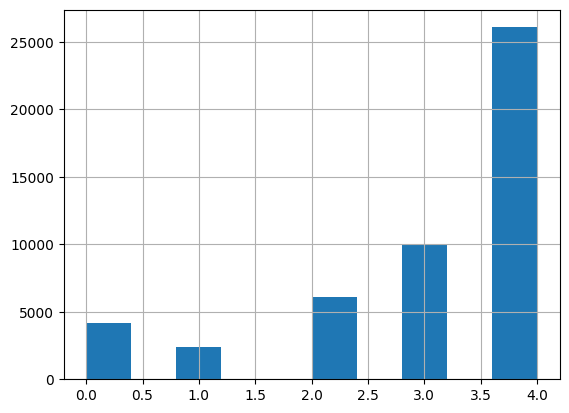

In [98]:
train_data['rate'].hist(); 

In [99]:
le = LabelEncoder()

train_data['rate'] = le.fit_transform(train_data['rate'])

# Оптимизация типов данных
train_data['rate'] = train_data['rate'].astype('uint8')

train_data.head()

,rate,text,clear_text
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться начало март собака дойти лес...
1,4,В целом магазин устраивает.\nАссортимент позво...,целое магазин устраивать ассортимент позволять...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень открыться ка далеко ехать рядом
3,2,Пятёрочка громко объявила о том как она заботи...,пята рочко громко объявить заботиться пенсионе...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока ряд трудно разойтись гря...


In [100]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rate        48665 non-null  uint8 
 1   text        48665 non-null  object
 2   clear_text  48543 non-null  object
dtypes: object(2), uint8(1)
memory usage: 808.0+ KB


## Подготовка и предварительная обработка данных

In [101]:
import re
import string

import nltk
import pymorphy2

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Загрузка русских стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Инициализируем стеммер
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    # Удаление лишних символов и нормализация
    text = text.lower()
    
    # Удаление знаков пунктуации
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    # Дополнительно: удаление специальных символов или любых символов, кроме букв (латиница или кириллица)
    text = re.sub(r"[^a-zA-Zа-яА-Я\s]", " ", text)

    # Удаление множество пробелов
    text = text.replace(r'\s+','')
    
    
    # Токенизация
    tokens = word_tokenize(text, language="russian")
    
    # Удаление стоп-слов и лемматизация
    # words_lemmatized = [morph.parse(word)[0].normal_form for word in tokens if word not in russian_stopwords]
    
    # Удаление стоп-слов и стемминг
    # words_stemmed = [stemmer.stem(word) for word in words if word not in russian_stopwords]
    
    return ' '.join(words_lemmatized)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
# Предварительная обработка текста
# train_data['clear_text'] = train_data['text'].apply(preprocess_text)


In [103]:
# test_data['clear_text'] = test_data['text'].apply(preprocess_text)

In [104]:
# train_data.to_csv(DATA_PATH+"train.csv", index=False)
# test_data.to_csv(DATA_PATH+"test.csv", index=False)

In [105]:
train_data = train_data.drop_duplicates(subset='clear_text', keep='last')
# train_data = train_data.reset_index(drop=True)
train_data['clear_text'] = train_data['clear_text'].astype('str')

## Конвертация текстов в векторы с использованием обученных эмбеддингов

In [106]:
# Функция для векторизации предложений
def vectorize_text(text, word_vectors):
    words = text.split()
    vectors = [word_vectors[word] for word in text if word in word_vectors]
    # Если векторы найдены, возвращаем средний вектор, иначе вектор нулей
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)

Своя модель

In [107]:
from gensim.models import Word2Vec

def get_word2vec_model(corpus_text: list[str], vector_size=100, window=5, min_count=1, workers=4):
    '''
    Ключевые параметры обучения Word2Vec:
        sentences: Итерируемый объект (например, список), содержащий предложения, где каждое предложение представлено списком слов.
        vector_size: Размерность векторов слов.
        window: Максимальное расстояние между текущим и предсказываемым словом в предложении.
        min_count: Игнорирует все слова с общей частотой ниже данного порога.
        workers: Количество потоков для использования во время обучения.
    '''
    tokens_list = [word_tokenize(tokens, language="russian") for tokens in corpus_text]
    model = Word2Vec(sentences=tokens_list, vector_size=300, window=8, min_count=1, workers=4)
    model.save("word2vec_model.model")
    return Word2Vec.load("word2vec_model.model")

In [108]:
# my_word_vectors_model = get_word2vec_model(train_data['clear_text'].values,
# 								  vector_size=VECTOR_SIZE,
# 								  window=VECTOR_WINDOW)
# my_word_vectors = my_word_vectors_model.wv

In [109]:

# # Получение вектора слова
# vector = my_word_vectors['машина']  # Получение вектора для слова 'машинного'

# # Поиск похожих слов
# similar_words = my_word_vectors.most_similar('молоко')
# print(similar_words)

In [110]:
# train_data['vector'] = train_data['clear_text'].apply(lambda text: vectorize_text(text, my_word_vectors))
# train_data['vector'].head(2)

Модель 65 с сайта

In [111]:
from gensim.models import KeyedVectors

# Путь к модели
path_to_model = DATA_PATH + '65/model.bin'

# Загрузка предварительно обученной модели (может потребовать много времени и памяти)
word_vectors = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

In [112]:
train_data['vector'] = train_data['clear_text'].apply(lambda text: vectorize_text(text, word_vectors))
train_data['vector'].head()

0    [0.277483, -0.33449414, 0.23901513, -0.2740655...
1    [0.25359327, -0.33535275, 0.2616323, -0.269437...
2    [0.23513529, -0.3578782, 0.32810014, -0.387764...
3    [0.2793653, -0.31477603, 0.26540235, -0.276298...
4    [0.26670524, -0.30488074, 0.2800383, -0.271650...
Name: vector, dtype: object

# Подготовка данных для PyTorch


In [113]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class TextDataset(Dataset):
    def __init__(self, vectors, labels):
        self.vectors = vectors.reset_index(drop=True) if isinstance(vectors, pd.Series) else vectors
        self.labels = labels.reset_index(drop=True) if isinstance(labels, pd.Series) else labels
    
    def __len__(self):
        return len(self.vectors)
    
    def __getitem__(self, idx):
        return torch.tensor(self.vectors[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(train_data['vector'].values, train_data['rate'].values, test_size=0.3, random_state=STATE, shuffle=True)

# X_train, X_test, y_train, y_test = train_test_split(train_data['vector'].values, train_data['rate'].values, test_size=0.2, random_state=STATE, stratify=train_data['rate'])


train_dataset = TextDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Тестовые данные
test_dataset = TextDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [115]:
# train_dataset[0]
# train_dataset[1]
# train_dataset[2]

# Модель
Модель TextCNN, предложенная Йун Кимом в 2014 году в статье "Convolutional Neural Networks for Sentence Classification", является одним из первых и наиболее влиятельных применений сверточных нейронных сетей (CNN) к задачам классификации текста. Эта модель использует операцию свертки для автоматического извлечения и обучения на важных локальных признаках предложений или документов для последующей классификации.

Основные компоненты модели TextCNN:
1. Встраивание слов (Word Embeddings):
Модель начинается с представления каждого слова в предложении через векторы встраивания слов (word embeddings), которые могут быть инициализированы случайным образом или использовать предварительно обученные векторы, такие как Word2Vec или GloVe. Эти векторы обучаются вместе с остальной моделью для оптимизации задачи классификации.

2. Слой свертки (Convolutional Layer):
Сверточные слои применяются к векторам встраивания слов для извлечения признаков из локальных контекстов слов. В TextCNN используются несколько фильтров (ядер свертки) различных размеров (например, размером 2, 3 и 4 слова), что позволяет модели извлекать информативные признаки из различных размеров n-граммов.

3. Слой пулинга (Pooling Layer):
После сверточных слоев следует операция пулинга, обычно максимального пулинга (max-pooling), которая агрегирует информацию по всей длине предложения, выбирая наиболее важные сигналы из каждого фильтра. Это позволяет модели быть инвариантной к длине входных текстов и сосредотачиваться на наиболее значимых признаках для классификации.

4. Полносвязный слой (Fully Connected Layer) и Классификация:
Извлеченные и агрегированные признаки затем передаются через один или несколько полносвязных слоев для дополнительной обработки. Последний слой модели обычно использует функцию softmax для вычисления вероятностей принадлежности к каждому из классов. В результате модель может классифицировать входное предложение или документ в одну из предопределенных категорий.

Входные параметры для класса TextCNN могут быть различными в зависимости от конкретной реализации и задачи. Ниже приведено подробное объяснение типичных входных параметров, используемых в модели TextCNN, адаптированной для классификации текста:

* __pretrained_embeddings__:
Тип: torch.Tensor
Описание: Тензор, содержащий предварительно обученные векторные представления слов (эмбеддинги). Эти векторы используются для инициализации первого слоя модели, отвечающего за преобразование индексов слов в векторы. Параметр freeze определяет, будут ли эмбеддинги обновляться в процессе обучения.

* __num_classes__:
Тип: int
Описание: Количество классов в задаче классификации. Этот параметр определяет размерность выходного слоя модели, поскольку выход модели должен представлять вероятности принадлежности к каждому из классов.

* __filter_sizes__: 
Тип: list из int
Описание: Список размеров фильтров (ядер) для сверточных слоев. Каждый размер фильтра соответствует "ширине" окна, через которое модель "смотрит" на входные данные, позволяя извлекать признаки из n-грамм различной длины. Например, filter_sizes=[3, 4, 5] означает, что будут использоваться три типа фильтров, обрабатывающие 3, 4 и 5 слов одновременно.

* __num_filters__:
Тип: int
Описание: Количество фильтров (или "каналов" в терминах сверточных сетей) для каждого размера фильтра. Этот параметр определяет "глубину" выучиваемых признаков: больше фильтров может позволить модели лучше абстрагироваться и извлекать более сложные признаки, но также увеличивает количество параметров модели и потребность в вычислительных ресурсах.

* __dropout__:
Тип: float
Описание: Параметр, контролирующий долю нейронов, которые случайным образом "отключаются" во время обучения для предотвращения переобучения. Значение 0.5 означает, что каждый нейрон имеет 50% шанс быть исключенным при каждом проходе вперед по сети во время обучения. Dropout помогает улучшить обобщающую способность модели.

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
class TextCNN(nn.Module):
    def __init__(self,
                 pretrained_embeddings, 
                 num_classes, 
                 filter_sizes=[3, 4, 5], 
                 num_filters=100,
                 dropout=0.8):
        
        super(TextCNN, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, pretrained_embeddings.size(1))) for k in filter_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [Batch, Sequence Length, Embedding Dim]
        x = x.unsqueeze(1)  # [Batch, 1, Sequence Length, Embedding Dim] для Conv2d
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # Применяем свертку и активацию
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # Максимальный пулинг
        x = torch.cat(x, 1)  # Конкатенация признаков из всех фильтров
        x = self.dropout(x)
        x = self.fc(x)
        return x


Чтобы адаптировать модель TextCNN под использование предварительно обученных векторов, предположим, что каждый "документ" или "текст" уже представлен усредненным вектором (или любым другим методом агрегации эмбеддингов). Модель должна быть способна принимать эти векторы напрямую без слоя эмбеддинга:


In [117]:

class AdaptedTextCNN(nn.Module):
    def __init__(self,
                 embedding_dim,  # Размерность предобученных эмбеддингов
                 num_classes, 
                 dropout=0.1):
        
        super(AdaptedTextCNN, self).__init__()
        
        # Полносвязные слои для классификации агрегированных эмбеддингов
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch_size, embedding_dim]
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        # x = self.dropout(x)
        x = self.fc3(x)
        return x

# Тренер

Класс Trainer был разработан для организации и упрощения процесса обучения моделей глубокого обучения в PyTorch. Он инкапсулирует логику обучения, валидации и тестирования, а также визуализацию результатов в единый интерфейс. Это позволяет избежать дублирования кода и делает эксперименты более структурированными и воспроизводимыми. Давайте подробно рассмотрим аргументы конструктора класса Trainer и их роли.

## Аргументы класса Trainer:
__model__:
Тип: torch.nn.Module
Описание: Это нейронная сеть, которую вы хотите обучить. Модель должна быть подклассом torch.nn.Module. Экземпляр модели будет использоваться для выполнения прямого распространения, обратного распространения и обновления весов.

__train_loader__:
Тип: torch.utils.data.DataLoader
Описание: DataLoader, который предоставляет доступ к обучающему набору данных. Он используется для итерации по обучающему датасету во время обучения модели. DataLoader обеспечивает эффективное извлечение данных с поддержкой многопоточности и батчинга.

__test_loader__:
Тип: torch.utils.data.DataLoader
Описание: Подобно train_loader, но предоставляет доступ к тестовому набору данных. Используется для оценки производительности модели на отдельном тестовом датасете после обучения.

__criterion__ (необязательный):
Тип: torch.nn.modules.loss._Loss
Описание: Функция потерь, используемая для оценки производительности модели и ее обучения. Примеры включают nn.CrossEntropyLoss для задач классификации или nn.MSELoss для регрессии. Если не указано, должно быть предоставлено значение по умолчанию внутри класса.

__optimizer__ (необязательный):
Тип: torch.optim.Optimizer
Описание: Оптимизатор, используемый для обновления весов модели в процессе обучения. Например, optim.Adam или optim.SGD. Как и в случае с criterion, если не указано, должно быть установлено значение по умолчанию.

__device__ (необязательный):
Тип: torch.device
Описание: Устройство, на котором должны выполняться вычисления (CPU или GPU). Это позволяет явно контролировать, где будут выполняться операции с тензорами и моделью. Если не указано, можно автоматически определить доступное устройство.

In [118]:
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score

class Trainer:
    def __init__(self, 
                 model: AdaptedTextCNN, 
                 train_loader, 
                 test_loader, 
                 criterion=None, 
                 optimizer=None, 
                 device='cpu'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion if criterion else nn.CrossEntropyLoss()
        self.optimizer = optimizer if optimizer else optim.Adam(model.parameters())
        self.device = device
        self.train_losses = []
        self.test_losses = []
        self.test_accuracies = []
        self.test_f1_scores = []

    # Обучение
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for vectors, labels in self.train_loader:
            vectors, labels = vectors.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()

            # print(self.model.state_dict())
   
      
            outputs = self.model(vectors)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
   
            # print(self.model.state_dict())
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(self.train_loader)
        self.train_losses.append(avg_loss)
        # print(f'Training Loss: {avg_loss:.4f}')

    def test_epoch(self):
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for vectors, labels in self.test_loader:
                vectors, labels = vectors.to(self.device), labels.to(self.device)               
    
                outputs = self.model(vectors)
                outputs = F.softmax(outputs, dim=1)  # Применяем softmax
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
        
                # outputs = self.model(vectors)    
                # loss = self.criterion(outputs, labels)
                # running_loss += loss.item()                
                # _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = running_loss / len(self.test_loader)
        accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        self.test_losses.append(avg_loss)
        self.test_accuracies.append(accuracy)
        self.test_f1_scores.append(f1)
        # print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    def fit(self, epochs):
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')
            self.train_epoch()
            self.test_epoch()
            print(f'Training Loss: {self.train_losses[-1]:.4f}, Test Loss: {self.test_losses[-1]:.4f}, Accuracy: {self.test_accuracies[-1]:.4f}, F1 Score: {self.test_f1_scores[-1]:.4f}')

    
    def plot_training(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(self.test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(self.test_f1_scores, label='Test F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('F1 Score over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Обучение

Чтобы использовать эмбеддинги, полученные с помощью модели Word2Vec, в обучении модели TextCNN на PyTorch, вам необходимо выполнить несколько шагов:

1. Извлечение матрицы весов эмбеддингов из обученной модели Word2Vec.
2. Создание слоя эмбеддингов в модели TextCNN с использованием извлеченной матрицы весов.
3. Адаптация данных под формат, принимаемый моделью TextCNN.

Device -  cpu
Epoch 1/100
Training Loss: 1.4000, Test Loss: 1.4736, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 2/100
Training Loss: 1.3036, Test Loss: 1.4826, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 3/100
Training Loss: 1.2982, Test Loss: 1.4812, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 4/100
Training Loss: 1.2949, Test Loss: 1.4855, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 5/100
Training Loss: 1.2898, Test Loss: 1.4805, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 6/100
Training Loss: 1.2822, Test Loss: 1.4709, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 7/100
Training Loss: 1.2705, Test Loss: 1.4650, Accuracy: 0.5143, F1 Score: 0.3493
Epoch 8/100
Training Loss: 1.2569, Test Loss: 1.4651, Accuracy: 0.5141, F1 Score: 0.3495
Epoch 9/100
Training Loss: 1.2433, Test Loss: 1.4562, Accuracy: 0.5142, F1 Score: 0.3500
Epoch 10/100
Training Loss: 1.2359, Test Loss: 1.4567, Accuracy: 0.5135, F1 Score: 0.3513
Epoch 11/100
Training Loss: 1.2282, Test Loss: 1.4613, Accuracy: 0.5135, F1 Score: 0.3554
Epoch

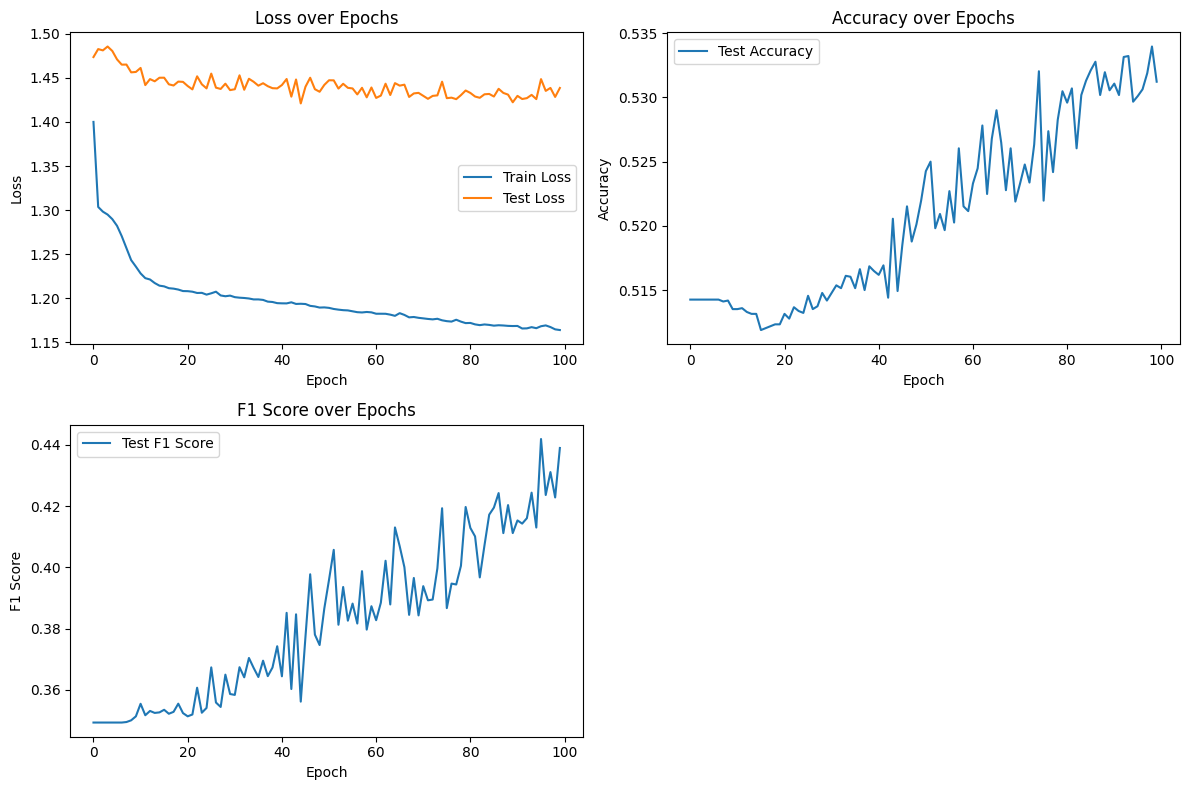

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device - ", device)
# # Получение матрицы весов эмбеддингов
# weights = torch.FloatTensor(my_word_vectors.vectors)
# vocab_size, embedding_dim = weights.size()

weights = torch.FloatTensor(word_vectors.vectors)
vocab_size, embedding_dim = weights.size()

# Создание экземпляра модели

# model = TextCNN(pretrained_embeddings=weights,
#                 num_classes=5,
#                 filter_sizes=[3, 4, 5], 
# 				num_filters=100,
# 				dropout=0.5).to(device)

model =  AdaptedTextCNN(embedding_dim=embedding_dim,
                num_classes=5,
                dropout=0.01).to(device)



# Создание экземпляра Trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)


# Запуск процесса обучения
trainer.fit(epochs=100)

# Визуализация процесса обучения
trainer.plot_training()


Epoch 1/100
Training Loss: 1.1449, Test Loss: 1.4132, Accuracy: 0.5357, F1 Score: 0.4279
Epoch 2/100
Training Loss: 1.1451, Test Loss: 1.4305, Accuracy: 0.5381, F1 Score: 0.4528
Epoch 3/100
Training Loss: 1.1468, Test Loss: 1.4163, Accuracy: 0.5354, F1 Score: 0.4264
Epoch 4/100
Training Loss: 1.1437, Test Loss: 1.4238, Accuracy: 0.5372, F1 Score: 0.4408
Epoch 5/100
Training Loss: 1.1542, Test Loss: 1.4380, Accuracy: 0.5348, F1 Score: 0.4527
Epoch 6/100
Training Loss: 1.1494, Test Loss: 1.4292, Accuracy: 0.5367, F1 Score: 0.4400
Epoch 7/100
Training Loss: 1.1437, Test Loss: 1.4211, Accuracy: 0.5384, F1 Score: 0.4436
Epoch 8/100
Training Loss: 1.1430, Test Loss: 1.4317, Accuracy: 0.5379, F1 Score: 0.4556
Epoch 9/100
Training Loss: 1.1457, Test Loss: 1.4166, Accuracy: 0.5366, F1 Score: 0.4345
Epoch 10/100
Training Loss: 1.1438, Test Loss: 1.4248, Accuracy: 0.5365, F1 Score: 0.4413
Epoch 11/100
Training Loss: 1.1449, Test Loss: 1.4216, Accuracy: 0.5381, F1 Score: 0.4427
Epoch 12/100
Traini

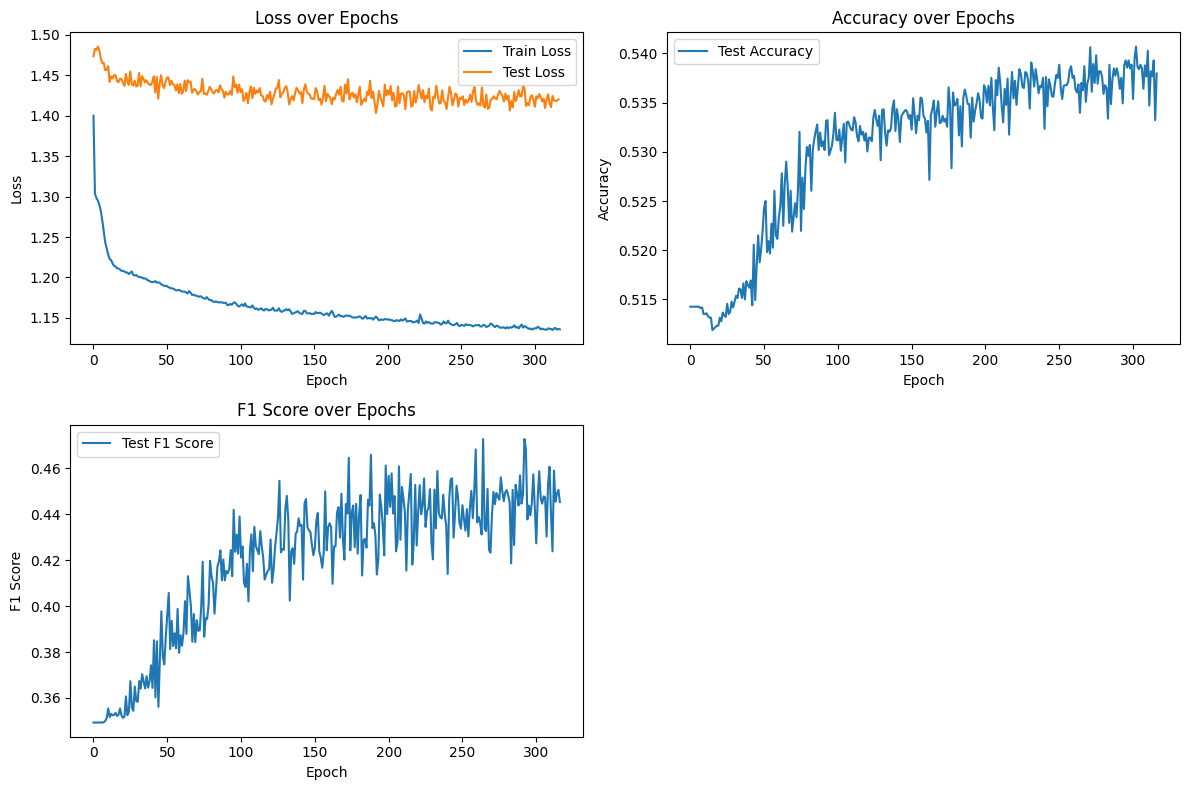

In [125]:
trainer.fit(epochs=100)
trainer.plot_training()



# Предикт

# Формирование решения

In [123]:
y_pred = logreg.predict_proba(test_data['clear_text'])
# Get classes
predictions = np.argmax(y_pred, axis=1)
# pred_labels = le.inverse_transform(preds)

sample_submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
sample_submission["rate"] = predictions
sample_submission.head()

NameError: name 'logreg' is not defined

In [ ]:
# sample_submission.to_csv(DATA_PATH+"submission.csv", index=False)